In [47]:
import SimpleITK as sitk
import os
import pandas as pd
import numpy as np
import time
import sys
import pydicom
import shutil
%matplotlib inline
import matplotlib.pyplot as plt

In [48]:
paths = [['cor/dicoms/in', 'cor/dicoms/out', 'cor/dicoms/fat', 'cor/dicoms/water'], ['cor/dicoms/b50', 'cor/dicoms/b900', 'cor/dicoms/adc']]
series_numbers = [[1, 2, 3, 4], [5, 7, 8]]
series_descriptons=  [['in', 'out', 'fat', 'water'], ['b50', 'b900', 'ADC']]

In [49]:
def load_sitk_image_volumes(paths, series_descriptions):
    imgs = []
    readers = []
    print('--- Loading Image Volumes in SimpleITK ---')
    for g, group in enumerate(paths):
        imgs.append([])
        readers.append([])
        for i, path in enumerate(group):
            for dirName, subdirList, fileList in os.walk(path):
                verbose_path = list(set([dirName for filename in fileList if filename.lower().endswith('.dcm')]))
                if len(verbose_path):  # this code is pretty gross but it works
                    print('"' + series_descriptions[g][i] + '"', 'image volume loaded')
                    reader = sitk.ImageSeriesReader()
                    dcm_names = reader.GetGDCMSeriesFileNames(verbose_path[0])
                    reader.SetFileNames(dcm_names)
                    reader.MetaDataDictionaryArrayUpdateOn()
                    reader.LoadPrivateTagsOn()
                    imgs[g].append(reader.Execute())
                    readers[g].append(reader)
    return imgs, readers

In [50]:
imgs, readers = load_sitk_image_volumes(paths, series_descriptons)

--- Loading Image Volumes in SimpleITK ---
"in" image volume loaded
"out" image volume loaded
"fat" image volume loaded
"water" image volume loaded
"b50" image volume loaded
"b900" image volume loaded
"ADC" image volume loaded


In [51]:
def myshow2(imgs, titles):
    n_col = max([len(group) for group in imgs])
    n_row = len(imgs)
    fig, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig.set_dpi(100)
    # fig.set_size_inches(20,6)
    for g, group in enumerate(imgs):
        i = 0
        for img, ax in (zip(group, axs[g])):
            spacing = img.GetSpacing()
            x_space = spacing[0]
            z_space = spacing[2]
            y = int(img.GetHeight()/1.7)
            nda_y = sitk.GetArrayViewFromImage(img)[:,y,:]
            x_size = nda_y.shape[1]
            z_size = nda_y.shape[0]
            extent = (0, x_size*x_space, z_size*z_space, 0)
            ax.set_title(titles[g][i])
            t = ax.imshow(nda_y,extent=extent,interpolation=None, origin='lower', 
                  cmap='Greys_r', vmin=nda_y.min(), vmax=nda_y.max()/2)
            i += 1
    fig.savefig("scans.pdf", bbox_inches='tight')
    for ax in axs.flatten():
        if not ax.images:
            ax.axis('off')

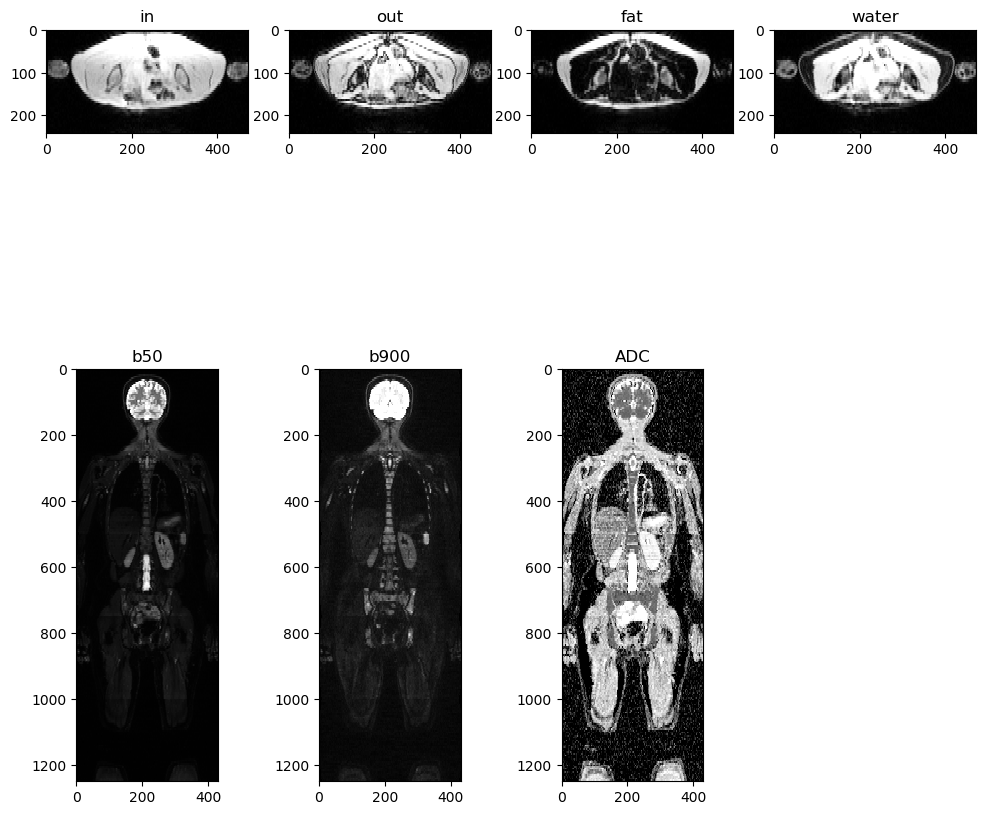

In [52]:
myshow2(imgs, series_descriptons)

In [58]:
img_cor = imgs[0][0]
img_tra = imgs[1][0]

In [60]:
print('Origin:', img_cor.GetOrigin())
print('Direction:', img_cor.GetDirection())
print('Spacing:', img_cor.GetSpacing())
print('FOV:', tuple(sp*si for sp, si in zip(img_cor.GetSpacing(), img_cor.GetSize())))
print('Size:', img_cor.GetSize())

Origin: (-238.93080139160156, -125.03215026855469, 200.0)
Direction: (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0)
Spacing: (2.4479167461395, 2.4479167461395, 5.0)
FOV: (472.44793200492353, 1297.395875453935, 240.0)
Size: (193, 530, 48)


In [61]:
print('Origin:', img_tra.GetOrigin())
print('Direction:', img_tra.GetDirection())
print('Spacing:', img_tra.GetSpacing())
print('FOV:', tuple(sp*si for sp, si in zip(img_tra.GetSpacing(), img_tra.GetSize())))
print('Size:', img_tra.GetSize())

Origin: (-213.5536346435547, -174.4127960205078, -1041.03369140625)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (1.5357142686844, 1.5357142686844, 5.0)
FOV: (429.999995231632, 343.99999618530563, 1250.0)
Size: (280, 224, 250)


In [ ]:
cor = [1, 0, 0, 0, 0, -1]
tra = [1, 0, 0, 0, 1, 0]

In [64]:
200 - 2.45*530

-1098.5

In [66]:
for g, group in enumerate(imgs):
    for i, img in enumerate(group):
        if img.GetDirection() == (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0):
                spacing = (img.GetSpacing()[0], img.GetSpacing()[2], img.GetSpacing()[1])
                size = (img.GetSize()[0], img.GetSize()[2], img.GetSize()[1])
                direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
                origin = (img.GetOrigin()[0], img.GetOrigin()[1], 
                          img.GetOrigin()[2] - img.GetSpacing()[1]*img.GetSize()[1])

                resample = sitk.ResampleImageFilter()
                resample.SetOutputSpacing(spacing)
                resample.SetSize(size)
                resample.SetOutputDirection(direction)
                resample.SetOutputOrigin(origin)
                resample.SetTransform(sitk.Transform())
                resample.SetDefaultPixelValue(3)
                resample.SetInterpolator(sitk.sitkLinear)
                
                imgs[g][i] = resample.Execute(img)

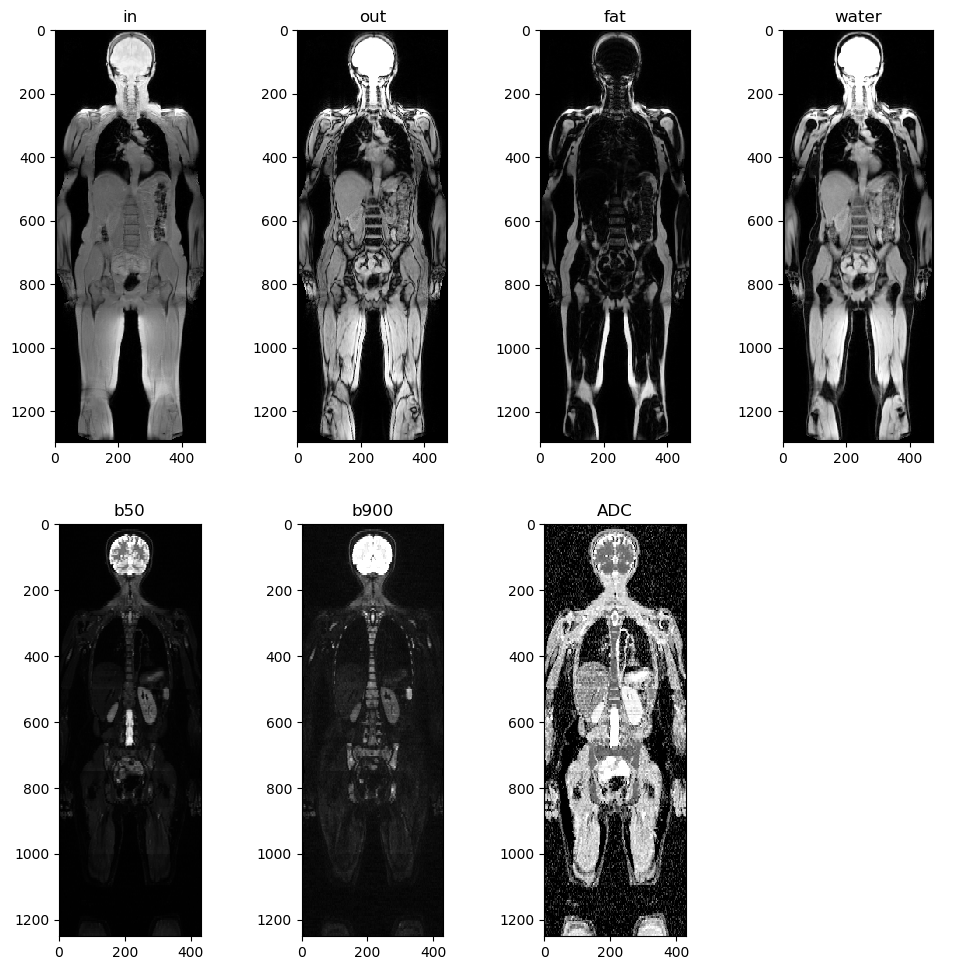

In [67]:
myshow2(imgs, series_descriptons)

In [68]:
def match_fovs_2(image_volumes, series_descriptons):
    imgs = [img for group in image_volumes for img in group]  # flattens nested list
    origin = tuple(np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3))
    fov = tuple(np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3))
    directions = [img.GetDirection() for img in imgs]
    direction = max(set(directions), key = directions.count)

    imgs_new = []

    for g, group in enumerate(image_volumes):
        spacings = [img.GetSpacing() for img in group]
        ref_spacing = max(set(spacings), key = spacings.count)

        ref_size = tuple(int(round(fov/spacing, 0)) for fov, spacing in zip(fov, ref_spacing))

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(ref_spacing)
        resample.SetSize(ref_size)
        resample.SetOutputDirection(direction)
        resample.SetOutputOrigin(origin)
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(3)
        resample.SetInterpolator(sitk.sitkLinear)
        
        print('Resampling Image Volumes:')
        imgs_new.append([resample.Execute(img) for img in group])
        
        for i, img in enumerate(group):
            print('-------',series_descriptons[g][i],'-------')
            print('Origin:', img.GetOrigin(), '---->', origin)
            print('Direction:', img.GetDirection(), '---->', direction)
            print('Spacing:', img.GetSpacing(), '---->', ref_spacing)
            print('FOV:', tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())), 
                  '---->', fov)
            print('Size:', img.GetSize(), '---->', ref_size)
            
    return imgs_new

In [69]:
imgs_new_2 = match_fovs_2(imgs, series_descriptons)

Resampling Image Volumes:
------- in -------
Origin: (-238.93080139160156, -125.03215026855469, -1097.395875453935) ----> (-213.5536346435547, -125.03215026855469, -1041.03369140625)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (2.4479167461395, 5.0, 2.4479167461395) ----> (2.4479167461395, 5.0, 2.4479167461395)
FOV: (472.44793200492353, 240.0, 1297.395875453935) ----> (429.999995231632, 240.0, 1250.0)
Size: (193, 48, 530) ----> (176, 48, 511)
------- out -------
Origin: (-238.93080139160156, -125.03215026855469, -1097.395875453935) ----> (-213.5536346435547, -125.03215026855469, -1041.03369140625)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (2.4479167461395, 5.0, 2.4479167461395) ----> (2.4479167461395, 5.0, 2.4479167461395)
FOV: (472.44793200492353, 240.0, 1297.395875453935) ----> (429.999995231632, 240.0, 1250.0)
Size: (193, 48, 530) ----

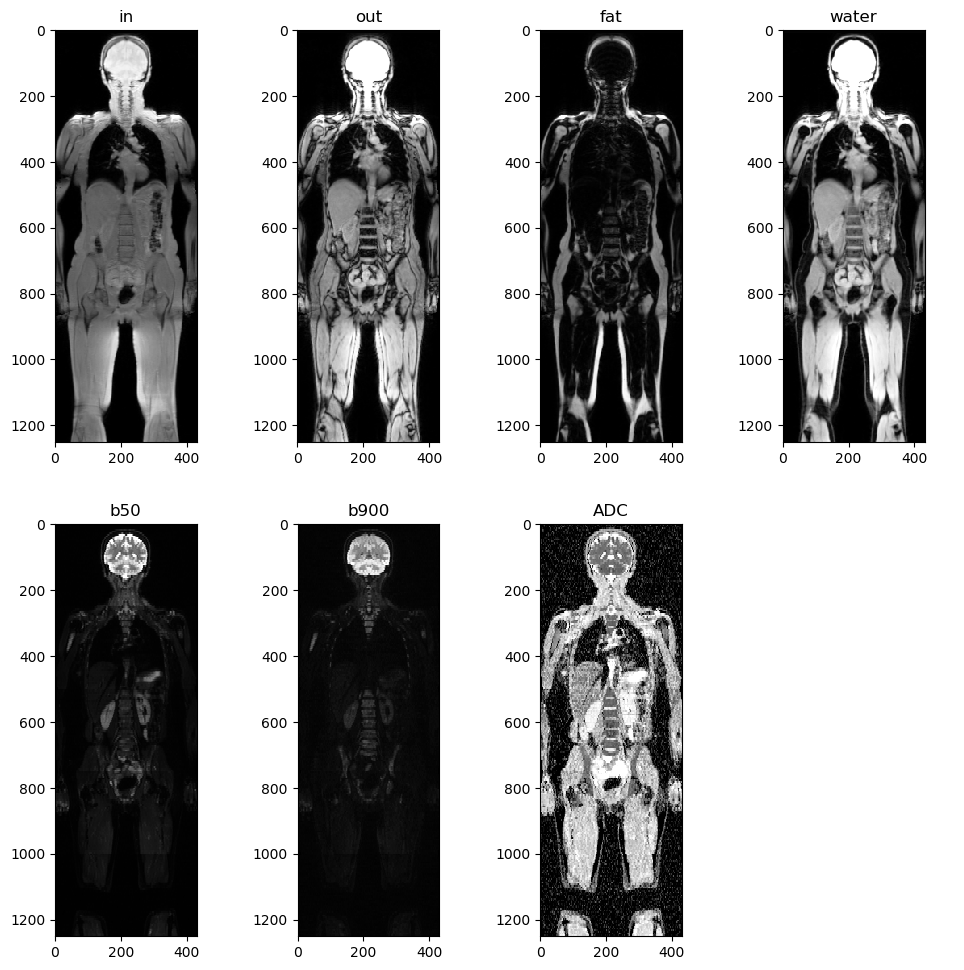

In [70]:
myshow2(imgs_new_2, series_descriptons)

In [71]:
def write_sitk_image_volumes(imgs, readers, series_descriptons, series_numbers):
    print('--- Writing DICOM Series from SimpleITK ---')
    shutil.rmtree('temp/dicoms_new', ignore_errors=True)
    os.mkdir('temp/dicoms_new')
    for g, group in enumerate(imgs):
        for i, img in enumerate(group):
            reader = readers[g][i]
            series_description = series_descriptons[g][i]
            series_number = series_numbers[g][i]

            os.mkdir(os.path.join('temp/dicoms_new/',series_description))

            writer = sitk.ImageFileWriter()
            writer.KeepOriginalImageUIDOn()

            tags_to_copy = ["0010|0010", # Patient Name
                            "0010|0020", # Patient ID
                            "0010|0030", # Patient Birth Date
                            "0010|0040", # Patient Sex
                            "0010|4000", # Patient Comments
                            "0020|000D", # Study Instance UID, for machine consumption
                            "0020|0010", # Study ID, for human consumption
                            "0008|0020", # Study Date
                            "0008|0030", # Study Time
                            "0008|0050", # Accession Number
                            "0008|0060", # Modality
                            "0018|5100"  # Patient Position
                           ]

            modification_time = time.strftime("%H%M%S")
            modification_date = time.strftime("%Y%m%d")

            direction = img.GetDirection()
            slice_thickness = str(img.GetSpacing()[2])

            series_tag_values = [(k, reader.GetMetaData(0,k)) for k in tags_to_copy if reader.HasMetaDataKey(0,k)] + \
                         [("0008|0031",modification_time), # Series Time
                          ("0008|0021",modification_date), # Series Date
                          ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                            direction[1],direction[4],direction[7])))),
                          ("0008|103e", series_description), # Series Description
                          ('0020|0011', str(series_number)), # Series Number
                          ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                          ("0020|000e", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.')), # Series Instance UID
                         ]
            for i in range(img.GetDepth()):
                image_slice = img[:,:,i]
                # Tags shared by the series.
                for tag, value in series_tag_values:
                    # print(tag)
                    image_slice.SetMetaData(tag, value)

                j = img.GetDepth() - i
                # Slice specific tags.
                image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
                image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time
                image_slice.SetMetaData("0020|0032", '\\'.join(map(str,img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
                image_slice.SetMetaData("0020|0013", str(j)) # Instance Number
                image_slice.SetMetaData("0018|0050", slice_thickness)
                image_slice.SetMetaData("0008|0018", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.'))

                # Write to the output directory and add the extension dcm, to force writing in DICOM format.

                writer.SetFileName(os.path.join('temp/dicoms_new',series_description, str(j)+'.dcm'))
                writer.Execute(image_slice)
            print('"' + series_description + '"', 'image volume saved')

In [72]:
write_sitk_image_volumes(imgs_new_2, readers, series_descriptons, series_numbers)

--- Writing DICOM Series from SimpleITK ---
"in" image volume saved
"out" image volume saved
"fat" image volume saved
"water" image volume saved
"b50" image volume saved
"b900" image volume saved
"ADC" image volume saved
